Я люблю фактчекать всякие штуки. Недавно в интернете форсили тему про огромные поступления на кошелек ФБК, которые якобы были украдены. Мне стало интересно проверить все самому. Для этого пришлось пописать немного кода.

Приглашаю всех, кому интересно, проверить мою логику и может дописать что-то. Ну и вообще, data science жеж :)

In [350]:
import os
import requests
import numpy as np
import pandas as pd
from datetime import date
pd.set_option("precision", 10)
pd.options.display.float_format = '{:,.10f}'.format

In [267]:
transactions_per_page = 100
address = '3QzYvaRFY6bakFBW4YBRrzmwzTnfZcaA6E'
api_url = 'https://api.smartbit.com.au/v1/blockchain/address/{}?limit={}'.format(address, transactions_per_page)
all_transactions = list()
all_outputs = list()
all_outputs.append("txid,time,value")
all_values = 0

Напишем небольшую штуку для забора всех данных про транзации с сайта, которые такие транзакции отдает без ключей и вот этого всего. Можно конечно их сразу обрабатывать, но я сваливаю все в одну кучу, чтобы можно бы сериализовать и не забирать данные каждый раз. 

Можно не забирать, а пойти ниже и просто восстановить сделки из файла, который я подготовил (NavCoinOutputs.csv).

In [276]:
_counter=0
def get_transactions(url):
    _data = requests.get(url).json()
    all_transactions.append(_data['address']['transactions'])
    _link = _data['address']['transaction_paging']['next_link']
    _counter+=1
    if _link:
        get_transactions(_link)
    else:
        print(f"Retrieved {_counter} documents with transactions data")

Теперь нужно вытащить из этой пачки данных все переводы на интересующий нас кошелек. Если я правильно понял, нам нужно только считать outcome транзакции на нужный адрес. Пробуем.

In [277]:
def pull_outputs():
    for tcollection in all_transactions:
        for transaction in tcollection:
            for output in transaction['outputs']:
                if address in output['addresses']:
                    _record = f"{transaction['txid']}, {transaction['time']}, {output['value']}"
                    all_values+=float(output['value'])
                    #print(_record)
                    all_outputs.append(_record)
    print(f"{len(all_outputs)} records with total value of {all_values}")

ок, запускаем

In [ ]:
get_transactions(api_url)
pull_outputs()

Теперь у нас есть пачка входных транзакций, будем с ней и работать. Всего выходит вроде верное количество битков, которые пришли на кошелек ФБК. Фишка в том, что когда они пришли, их цена была не такой, какая цена на биток сейчас, ну и курс доллара тоже. То есть, если в 16 году биток стоил стоил 500, а сейчас 40К, это не значит, что на кошельке ФБК в 16 году было 40К. Короче, надо считать по цене на день, когда биток пришел (цену в день вывода можно игнорировать имхо), для упрощения можно считать ценность битка в долларах на день, когда он прилетел на кошелек.

Чтобы не возвращаться к сбору данных каждый раз, их можно сохранить.

In [107]:
with open("NavCoinOutputs.csv", "w") as f:
    for r in all_outputs:
        f.write(f"{str(r)}\n")

Ну теперь погнали, загрузим все в таблицу.

In [397]:
trans = pd.read_csv("NavCoinOutputs.csv")

Посмотрим, сколько денег всего пришло (вроде похоже на правду? https://www.blockchain.com/btc/address/3QzYvaRFY6bakFBW4YBRrzmwzTnfZcaA6E)

In [398]:
trans['value'].sum()

657.1755495

Теперь надо прикинуть, сколько пришедшие битки стоили в день поступления в долларах и рублях (опять по курсу на день) и тогда можно будет примерно понять, что да как. Данные по рурсам битка с доллару и рублю к доллару я брал на finance.yahoo.com, файлики кладу здесь.

In [330]:
prices = pd.read_csv('BTC-USD.csv')
prices['Date'] = pd.to_datetime(prices["Date"])
prices.head()

Date                 Open                 High                  Low  \
0 2016-01-02               434.62               436.06               431.87   
1 2016-01-03               433.58               433.74               424.71   
2 2016-01-04               430.06               434.52               429.08   
3 2016-01-05               433.07               434.18               429.68   
4 2016-01-06               431.86               431.86               426.34   

                 Close            Adj Close               Volume  
0               433.44               433.44        30,096,600.00  
1               430.01               430.01        39,633,800.00  
2               433.09               433.09        38,477,500.00  
3               431.96               431.96        34,522,600.00  
4               429.11               429.11        34,042,500.00

In [317]:
rub_rates = pd.read_csv('USDRUB=X.csv')
rub_rates["Date"] = pd.to_datetime(rub_rates["Date"])
rub_rates.head()

Date                 Open                 High                  Low  \
0 2016-01-01                73.82                73.82                73.40   
1 2016-01-04                72.94                72.94                72.94   
2 2016-01-05                73.14                73.36                73.14   
3 2016-01-06                74.03                74.03                74.03   
4 2016-01-07                75.49                75.49                74.68   

                 Close            Adj Close               Volume  
0                73.23                73.23                 0.00  
1                73.40                73.40                 0.00  
2                73.12                73.12                 0.00  
3                 0.72                 0.72                 0.00  
4                74.60                74.60                 0.00

Теперь надо привести в порядок транзакции, добавить нормальное время, чтобы можно было по этому времени привязывать цены рубля и битка, ну и отсортировать и все такое.

In [399]:
trans['date'] = pd.to_datetime(trans['time'], unit='s').dt.date
trans['date'] = pd.to_datetime(trans['date'])
trans.sort_values('time', ascending=True, inplace=True)
trans.sort_index(inplace=True)
trans.sample()

txid        time  \
1001  7730ff06213a7281d86e3bfb659b3dd47ae669c90cc96b...  1576227554   

            value       date  
1001 0.0022200000 2019-12-13

Теперь попробуем проставить рейт на каждый день с транзакцией, чтобы потом посчитать ее ценность в долларах.

In [400]:
def get_BTCUSD(date):
    return prices.loc[prices['Date'] == date]["Close"].values[0]
trans["BTCUSD"] = trans['date'].apply(get_BTCUSD)

In [401]:
trans

txid        time  \
0     0932302813e3f009493860d130929a11fcaddd3a86349d...  1611745141   
1     2352f43ba1fb8b21f0f0dd03d11bac03b5e345d2d07fd3...  1611733082   
2     df8e2bd0237f3f660d60ae8af01820b40b54ec3878fe90...  1611724591   
3     791de9b977b470a3d1f283118d794da0ffaedc47fd911a...  1611724591   
4     1c8f1fa4bd95836d152e7e908bc4f3846eeb1a1f7d41a2...  1611696126   
...                                                 ...         ...   
3595  f2a9766cc08fd96a051ebb5a388bf7188c85dfd19d7c2f...  1481627928   
3596  c3a923695f3eca21216785e4fb52a2b4c48c44620a0222...  1481625592   
3597  22e19e1a024a8bf506ffc28e6124a385087e73be469143...  1481624235   
3598  2df9478d1f794028ee4b4e8385997ea6e6dd3edf693082...  1481622992   
3599  cdd553cf77d1c848827bacc680e6ebbd83dd404738bb75...  1481215473   

            value       date            BTCUSD  
0    0.0016934200 2021-01-27 30,739.0136720000  
1    0.0019263200 2021-01-27 30,739.0136720000  
2    0.0018336000 2021-01-27 30,739.0136720000  
3    0.0022156000 2021-01-27 30,739.0136720000  
4    0.0025027200 2021-01-26               NaN  
...           ...        ...               ...  
3595 0.0173531000 2016-12-13    780.5560300000  
3596 0.0300000000 2016-12-13    780.5560300000  
3597 0.0200000000 2016-12-13    780.5560300000  
3598 0.0500000000 2016-12-13    780.5560300000  
3599 0.0096000000 2016-12-08    770.8099980000  

[3600 rows x 5 columns]

Как видно, долларовые рейты есть не на все даты, итнересно, почему? А, вероятно, потому что у меня данные по рейтам старые (не, в исходном файле они нулевые, я хз почему). Это можно починить довольно легко - будем брать для пустых записей самые ближайшие исторические непустые данные.

In [402]:
trans["BTCUSD"].ffill(inplace=True)
trans

txid        time  \
0     0932302813e3f009493860d130929a11fcaddd3a86349d...  1611745141   
1     2352f43ba1fb8b21f0f0dd03d11bac03b5e345d2d07fd3...  1611733082   
2     df8e2bd0237f3f660d60ae8af01820b40b54ec3878fe90...  1611724591   
3     791de9b977b470a3d1f283118d794da0ffaedc47fd911a...  1611724591   
4     1c8f1fa4bd95836d152e7e908bc4f3846eeb1a1f7d41a2...  1611696126   
...                                                 ...         ...   
3595  f2a9766cc08fd96a051ebb5a388bf7188c85dfd19d7c2f...  1481627928   
3596  c3a923695f3eca21216785e4fb52a2b4c48c44620a0222...  1481625592   
3597  22e19e1a024a8bf506ffc28e6124a385087e73be469143...  1481624235   
3598  2df9478d1f794028ee4b4e8385997ea6e6dd3edf693082...  1481622992   
3599  cdd553cf77d1c848827bacc680e6ebbd83dd404738bb75...  1481215473   

            value       date            BTCUSD  
0    0.0016934200 2021-01-27 30,739.0136720000  
1    0.0019263200 2021-01-27 30,739.0136720000  
2    0.0018336000 2021-01-27 30,739.0136720000  
3    0.0022156000 2021-01-27 30,739.0136720000  
4    0.0025027200 2021-01-26 30,739.0136720000  
...           ...        ...               ...  
3595 0.0173531000 2016-12-13    780.5560300000  
3596 0.0300000000 2016-12-13    780.5560300000  
3597 0.0200000000 2016-12-13    780.5560300000  
3598 0.0500000000 2016-12-13    780.5560300000  
3599 0.0096000000 2016-12-08    770.8099980000  

[3600 rows x 5 columns]

ок, теперь можно перемножить колонки и посмотреть, сколько в итоге ФБК получил битка в пересчете на доллары по курсу на день их завода

In [406]:
trans["USDValue"] = trans["value"] * trans["BTCUSD"]
trans["USDValue"].sum()

3600999.8294924125

ok, вышло 3 миллиона 600к, теперь можно пересчитать это в рублики (вообще, это можно было сделать и раньше сразу напрямую, но я затупил)

In [413]:
def get_USDRUB(date):
    try:
        return rub_rates.loc[rub_rates["Date"] == date]["Close"].values[0]
    except:
        return np.NaN
trans["USDRUB"] = trans["date"].apply(get_USDRUB)
trans["USDRUB"].ffill(inplace=True)
trans["RUBValue"] = trans["USDValue"] * trans["USDRUB"]
trans["RUBValue"].sum()

226980460.08781552

Вышло 227 миллионов (уж никак не полтора миллиарда, как утверждают, например, здесь: https://twitter.com/_GeNa_BOBkOFF/status/1354314396453974020?s=20)

А можно порисовать эти поступления и увидеть, что конечно же размер большинства переводов в среднем сравнительно небольшой. Короче, было бы неплохо, если бы кто-то проверил мои баги и ошибки, но походу ватники опять врут.

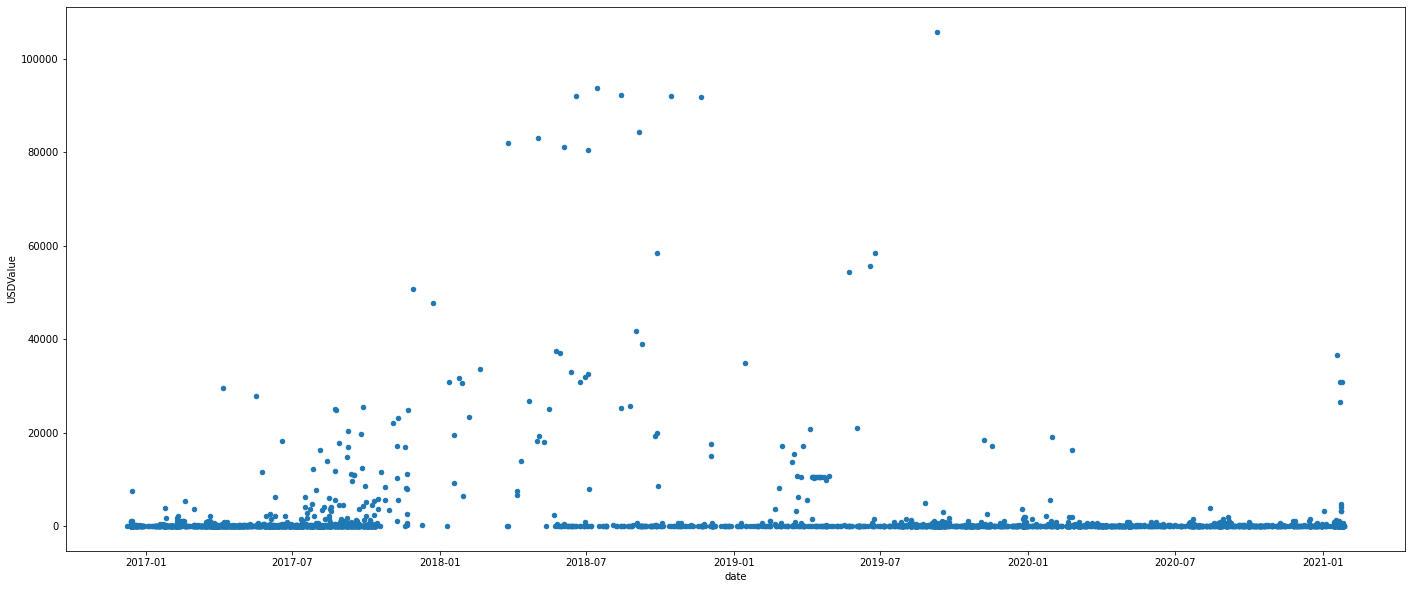

In [414]:
import matplotlib.pyplot as plt
trans.plot.scatter(x="date", y="USDValue", figsize=(24,10))
plt.show()